In [1]:
import os, csv,sys
import io, textwrap, itertools
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
csv.field_size_limit(sys.maxsize)


common_nucleotide_set = {'A', 'T', 'C', 'G', 'U', 'N'}

# not {'O', 'U', 'Z', 'J', 'B'}
# Common amino acids
common_amino_acid_set = {'R', 'X', 'S', 'G', 'W', 'I', 'Q', 'A', 'T', 'V', 'K', 'Y', 'C', 'N', 'L', 'F', 'D', 'M', 'P', 'H', 'E'}


def clean_seq(protein_id, seq):
    seq = seq.upper()
    new_seq = ""
    has_invalid_char = False
    invalid_char_set = set()
    for ch in seq:
        if 'A' <= ch <= 'Z' and ch not in ['J']:
            new_seq += ch
        else:
            invalid_char_set.add(ch)
            has_invalid_char = True
    if has_invalid_char:
        print("id: %s. Seq: %s" % (protein_id, seq))
        print("invalid char set:", invalid_char_set)
    return new_seq


def file_reader(filename, header=True, header_filter=True):
    if filename.endswith(".fa") or filename.endswith(".fas") or filename.endswith(".fasta"):
        return fasta_reader(filename)
    elif filename.endswith(".csv"):
        return csv_reader(filename, header=True, header_filter=True)
    elif filename.endswith(".tsv"):
        return tsv_reader(filename, header=True, header_filter=True)
    else:
        return txt_reader(filename, header=header, header_filter=header_filter)


def txt_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        cnt = 0
        for line in handle:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield line.strip()
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def tsv_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        reader = csv.reader(handle, delimiter="\t")
        cnt = 0
        for row in reader:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield row
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def csv_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        # data = csv.reader((line.replace('\0','') for line in data_initial), delimiter=",")
        # reader = csv.reader(handle)
        reader = csv.reader((line.replace('\0', '') for line in handle))
        cnt = 0
        for row in reader:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield row
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def txt_writer(dataset, handle, header=None):
    '''
    txt 写
    :param dataset: 数据
    :param handle: 文件
    :param header: 头
    :return:
    '''
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'w')
    try:
        if header:
            if isinstance(header, list):
                handle.write(",".join(header) + "\n")
            else:
                handle.write(header + "\n")
        print("header: %s" %header)
        for row in dataset:
            handle.write(str(row) + "\n")
    except Exception as e:
        raise e
    finally:
        if not handle.closed:
            handle.close()
    '''
    with open(handle, "w") as wfp:
        if header:
            if isinstance(header, list):
                wfp.write(",".join(header) + "\n")
            else:
                wfp.write(header + "\n")
        for row in dataset:
            wfp.write(str(row) + "\n")


def csv_writer(dataset, handle, header):
    '''
    csv 写，适合大文件
    :param dataset: 数据
    :param handle: 文件
    :param header: 头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'w')
    try:
        writer = csv.writer(handle)
        if header:
            writer.writerow(header)
        for row in dataset:
            writer.writerow(row)
    except Exception as e:
        raise e
    finally:
        if not handle.closed:
            handle.close()


def fasta_reader(handle, width=None):
    """
    Reads a FASTA file, yielding header, sequence pairs for each sequence recovered 适合大文件
    args:
        :handle (str, pathliob.Path, or file pointer) - fasta to read from
        :width (int or None) - formats the sequence to have max `width` character per line.
                               If <= 0, processed as None. If None, there is no max width.
    yields:
        :(header, sequence) tuples
    returns:
        :None
    """
    FASTA_STOP_CODON = "*"

    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    width = width if isinstance(width, int) and width > 0 else None
    try:
        header = None
        for is_header, group in itertools.groupby(handle, lambda line: line.startswith(">")):
            if is_header:
                header = group.__next__().strip()
            else:
                seq = ''.join(line.strip() for line in group).strip().rstrip(FASTA_STOP_CODON)
                if width is not None:
                    seq = textwrap.fill(seq, width)
                yield header, seq
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def write_fasta(filepath, sequences):
    '''
    write fasta file
    :param filepath: savepath
    :param sequences: fasta sequence(each item: [id, seq])
    :return:
    '''

    if sequences:
        with open(filepath, "w") as output_handle:
            if len(sequences[0]) > 1 and isinstance(sequences[0][0], str):
                for row in sequences:
                    protein_id = row[0]
                    seq = row[1]
                    sequence = SeqRecord(Seq(seq, None), id=protein_id[1:] if protein_id and protein_id[0] == ">" else protein_id, description="")
                    SeqIO.write(sequence, output_handle, "fasta")
            else:
                for sequence in sequences:
                    SeqIO.write(sequence, output_handle, "fasta")


In [2]:
query_seq_ids_dev = set()
for row in fasta_reader("./fasta/lucapcycle_extra_p_2_class_v3_case_01_dev.fasta"):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    query_seq_ids_dev.add(seq_id)
print("query_seq_ids_dev: %d" % len(query_seq_ids_dev))

query_seq_ids_test = set()
for row in fasta_reader("./fasta/lucapcycle_extra_p_2_class_v3_case_01_test.fasta"):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    query_seq_ids_test.add(seq_id)
print("query_seq_ids_test: %d" % len(query_seq_ids_test))

target_seq_ids = set()
for row in fasta_reader("./fasta/lucapcycle_extra_p_2_class_v3_case_01_train.fasta"):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    target_seq_ids.add(seq_id)
print("target_seq_ids: %d" % len(target_seq_ids))

query_seq_ids_dev: 106780
query_seq_ids_test: 106780
target_seq_ids: 854248


In [3]:
query_seq_id_set_dev = set()
target_seq_id_set_dev = set()
query_seq_id_sim_dev = {}
min_sim_dev = 1.0
max_sim_dev = 0.0
for row in tsv_reader(
    "./fasta/diamond_against/lucapcycle_extra_p_2_class_v3_case_01_dev_against_lucapcycle_extra_p_2_class_v3_case_01_train.tsv",
    header=True, 
    header_filter=True
):
    query_seq_id_dev, target_seq_id_dev, sim_dev = row[0], row[2], float(row[5])/100
    query_seq_id_set_dev.add(query_seq_id_dev)
    target_seq_id_set_dev.add(target_seq_id_dev)
    if query_seq_id_dev not in query_seq_id_sim_dev or sim_dev > query_seq_id_sim_dev[query_seq_id_dev]:
        query_seq_id_sim_dev[query_seq_id_dev] = sim_dev
    if sim_dev < min_sim_dev:
        min_sim_dev = sim_dev
    if sim_dev > max_sim_dev:
        max_sim_dev = sim_dev
print("query_seq_id_set_dev: %d" % len(query_seq_id_set_dev))
print("target_seq_id_set_dev: %d" % len(target_seq_id_set_dev))
print("min_sim_dev: %f" % min_sim_dev)
print("max_sim_dev: %f" % max_sim_dev)

query_seq_id_set_dev: 81883
target_seq_id_set_dev: 330499
min_sim_dev: 0.177000
max_sim_dev: 1.000000


In [4]:
query_seq_id_set_test = set()
target_seq_id_set_test = set()
query_seq_id_sim_test = {}
min_sim_test = 1.0
max_sim_test = 0.0
for row in tsv_reader(
    "./fasta/diamond_against/lucapcycle_extra_p_2_class_v3_case_01_test_against_lucapcycle_extra_p_2_class_v3_case_01_train.tsv",
    header=True, 
    header_filter=True
):
    query_seq_id_test, target_seq_id_test, sim_test = row[0], row[2], float(row[5])/100
    query_seq_id_set_test.add(query_seq_id_test)
    target_seq_id_set_test.add(target_seq_id_test)
    if query_seq_id_test not in query_seq_id_sim_test or sim_test > query_seq_id_sim_test[query_seq_id_test]:
        query_seq_id_sim_test[query_seq_id_test] = sim_test
    if sim_test < min_sim_test:
        min_sim_test = sim_test
    if sim_test > max_sim_test:
        max_sim_test = sim_test
print("query_seq_id_set_test: %d" % len(query_seq_id_set_test))
print("target_seq_id_set_test: %d" % len(target_seq_id_set_test))
print("min_sim_test: %f" % min_sim_test)
print("max_sim_test: %f" % max_sim_test)

query_seq_id_set_test: 81792
target_seq_id_set_test: 330390
min_sim_test: 0.176000
max_sim_test: 1.000000


In [5]:
print(len(query_seq_id_set_dev & query_seq_ids_dev))
print(len(target_seq_id_set_dev & target_seq_ids))

print(len(query_seq_id_set_test & query_seq_ids_test))
print(len(target_seq_id_set_test & target_seq_ids))


81883
330499
81792
330390


In [6]:
sim_section_names = [
    "(, 0.2)", 
    "[0.2, 0.3)",
    "[0.3, 0.4)", 
    "[0.4, 0.5)", 
    "[0.5, 0.6)", 
    "[0.6, 0.7)",
    "[0.7, 0.8)",
    "[0.8, 0.9)",
    "[0.9, 1.0)",
    "=1.0"
]

In [7]:
sim_values_dev = list(query_seq_id_sim_dev.values())

sim_section_dev = [0] * len(sim_section_names)
for sim in sim_values_dev:
    if sim < 0.2:
        idx = 0
    elif sim < 0.3:
        idx = 1
    elif sim < 0.4:
        idx = 2
    elif sim < 0.5:
        idx = 3
    elif sim < 0.6:
        idx = 4
    elif sim < 0.7:
        idx = 5
    elif sim < 0.8:
        idx = 6
    elif sim < 0.9:
        idx = 7
    elif sim < 1.0:
        idx = 8
    else:
        idx = 9
    sim_section_dev[idx] += 1
sim_section_dev[0] += (len(query_seq_ids_dev) - len(sim_values_dev))
for idx, name in enumerate(sim_section_names):
    print("%s:%d" % (name, sim_section_dev[idx]))
    
sim_values_test = list(query_seq_id_sim_test.values())

sim_section_test = [0] * len(sim_section_names)
for sim in sim_values_test:
    if sim < 0.2:
        idx = 0
    elif sim < 0.3:
        idx = 1
    elif sim < 0.4:
        idx = 2
    elif sim < 0.5:
        idx = 3
    elif sim < 0.6:
        idx = 4
    elif sim < 0.7:
        idx = 5
    elif sim < 0.8:
        idx = 6
    elif sim < 0.9:
        idx = 7
    elif sim < 1.0:
        idx = 8
    else:
        idx = 9
    sim_section_test[idx] += 1
sim_section_test[0] += (len(query_seq_ids_test) - len(sim_values_test))
for idx, name in enumerate(sim_section_names):
    print("%s:%d" % (name, sim_section_test[idx]))
    

# for merged
sim_values_dev_test = list(query_seq_id_sim_dev.values()) + list(query_seq_id_sim_test.values())

query_seq_ids_dev_test =query_seq_ids_dev | query_seq_ids_test
sim_section_dev_test = [0] * len(sim_section_names)
for sim in sim_values_dev_test:
    if sim < 0.2:
        idx = 0
    elif sim < 0.3:
        idx = 1
    elif sim < 0.4:
        idx = 2
    elif sim < 0.5:
        idx = 3
    elif sim < 0.6:
        idx = 4
    elif sim < 0.7:
        idx = 5
    elif sim < 0.8:
        idx = 6
    elif sim < 0.9:
        idx = 7
    elif sim < 1.0:
        idx = 8
    else:
        idx = 9
    sim_section_dev_test[idx] += 1
sim_section_dev_test[0] += (len(query_seq_ids_dev_test) - len(sim_values_dev_test))
for idx, name in enumerate(sim_section_names):
    print("%s:%d" % (name, sim_section_dev_test[idx]))
    
    
if not os.path.exists("./pic/"):
    os.makedirs("./pic/")
    

(, 0.2):24901
[0.2, 0.3):2040
[0.3, 0.4):11541
[0.4, 0.5):23874
[0.5, 0.6):14244
[0.6, 0.7):7016
[0.7, 0.8):5510
[0.8, 0.9):6046
[0.9, 1.0):11425
=1.0:183
(, 0.2):24994
[0.2, 0.3):2183
[0.3, 0.4):11433
[0.4, 0.5):23864
[0.5, 0.6):14295
[0.6, 0.7):6811
[0.7, 0.8):5464
[0.8, 0.9):6249
[0.9, 1.0):11337
=1.0:150
(, 0.2):49895
[0.2, 0.3):4223
[0.3, 0.4):22974
[0.4, 0.5):47738
[0.5, 0.6):28539
[0.6, 0.7):13827
[0.7, 0.8):10974
[0.8, 0.9):12295
[0.9, 1.0):22762
=1.0:333


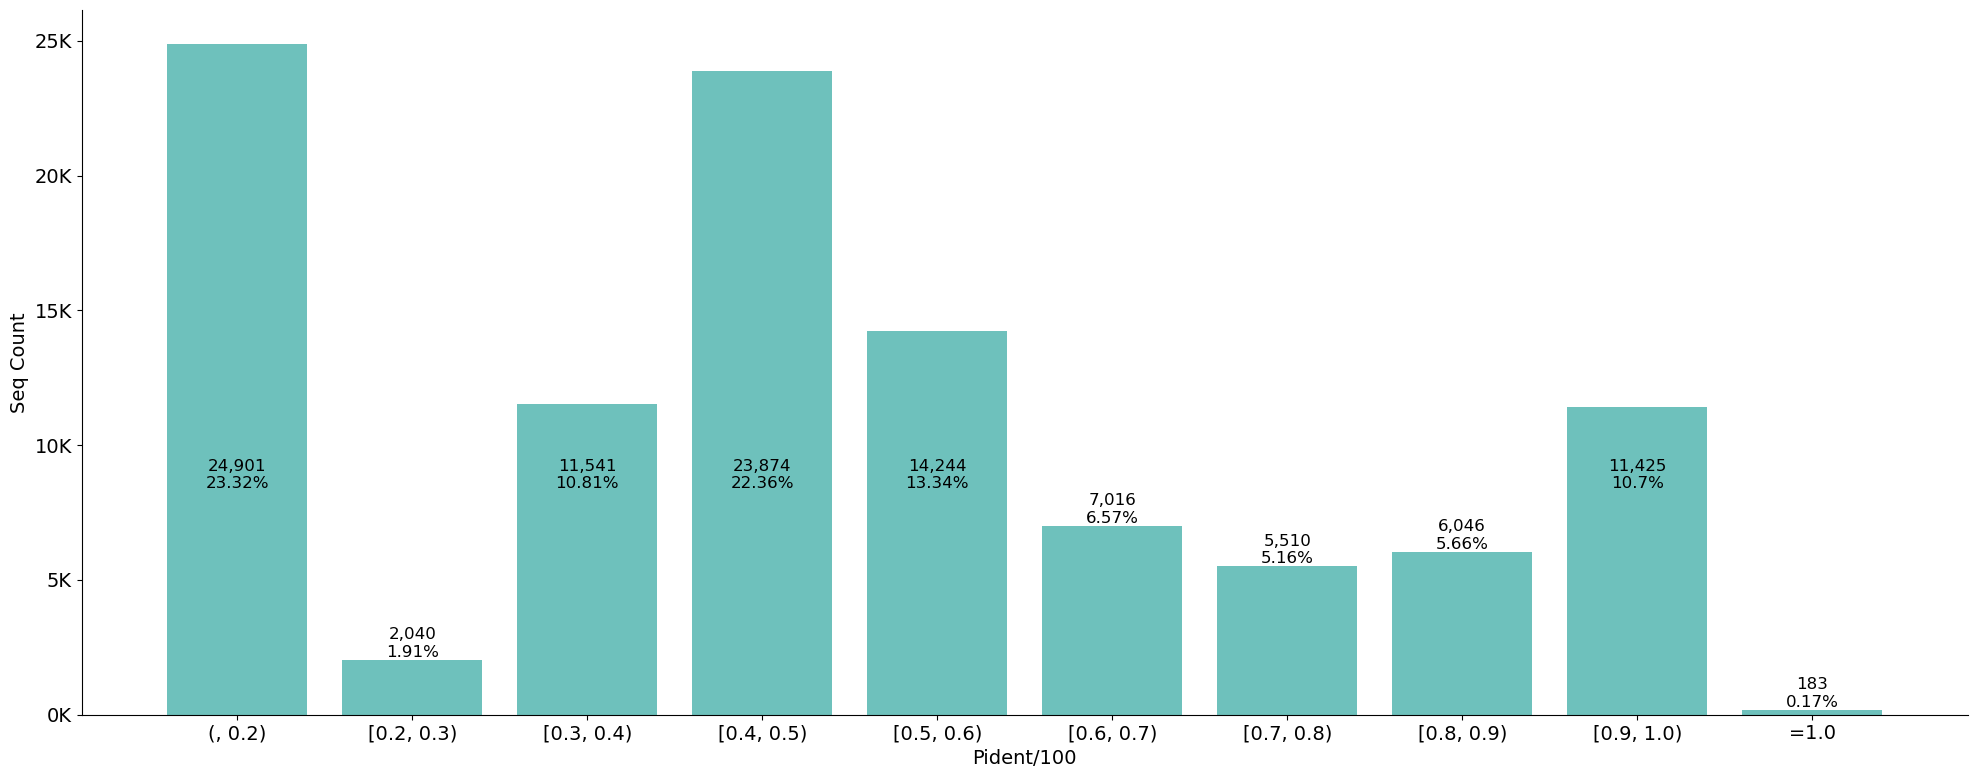

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['font.size'] = 14

# 数据准备
categories = sim_section_names
values_dev = sim_section_dev
sum_value_dev = sum(values_dev)

plt.figure(figsize=(20, 8))

# 绘制柱状图
plt.bar(categories, values_dev, color='#6ec1bc')

for i, value in enumerate(values_dev):

    y =  min(max(values_dev)/3, value)
    plt.text(
        i, 
        y, 
        f"{value:,}" + "\n" + str(round(100 * value/sum_value_dev, 2)) + "%", 
        ha='center',
        va='bottom',
        fontsize=12
    )

# 添加标题和标签
# plt.title('Similarity Distribution')
plt.xlabel('Pident/100')
plt.ylabel('Seq Count')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 定义格式化函数
def thousands_formatter(x, pos):
    return f'{int(x/1000)}K'

# 应用格式化到y轴
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

# 调整布局防止重叠
plt.tight_layout()  

# 显示图形
plt.savefig("./pic/Fig.LucapCycle_Extra_P_2_Class_v3_case_01_dev_against_train.png", dpi=600,  format='png')
plt.savefig("./pic/Fig.LucapCycle_Extra_P_2_Class_v3_case_01_dev_against_train.pdf", dpi=600,  format='pdf')

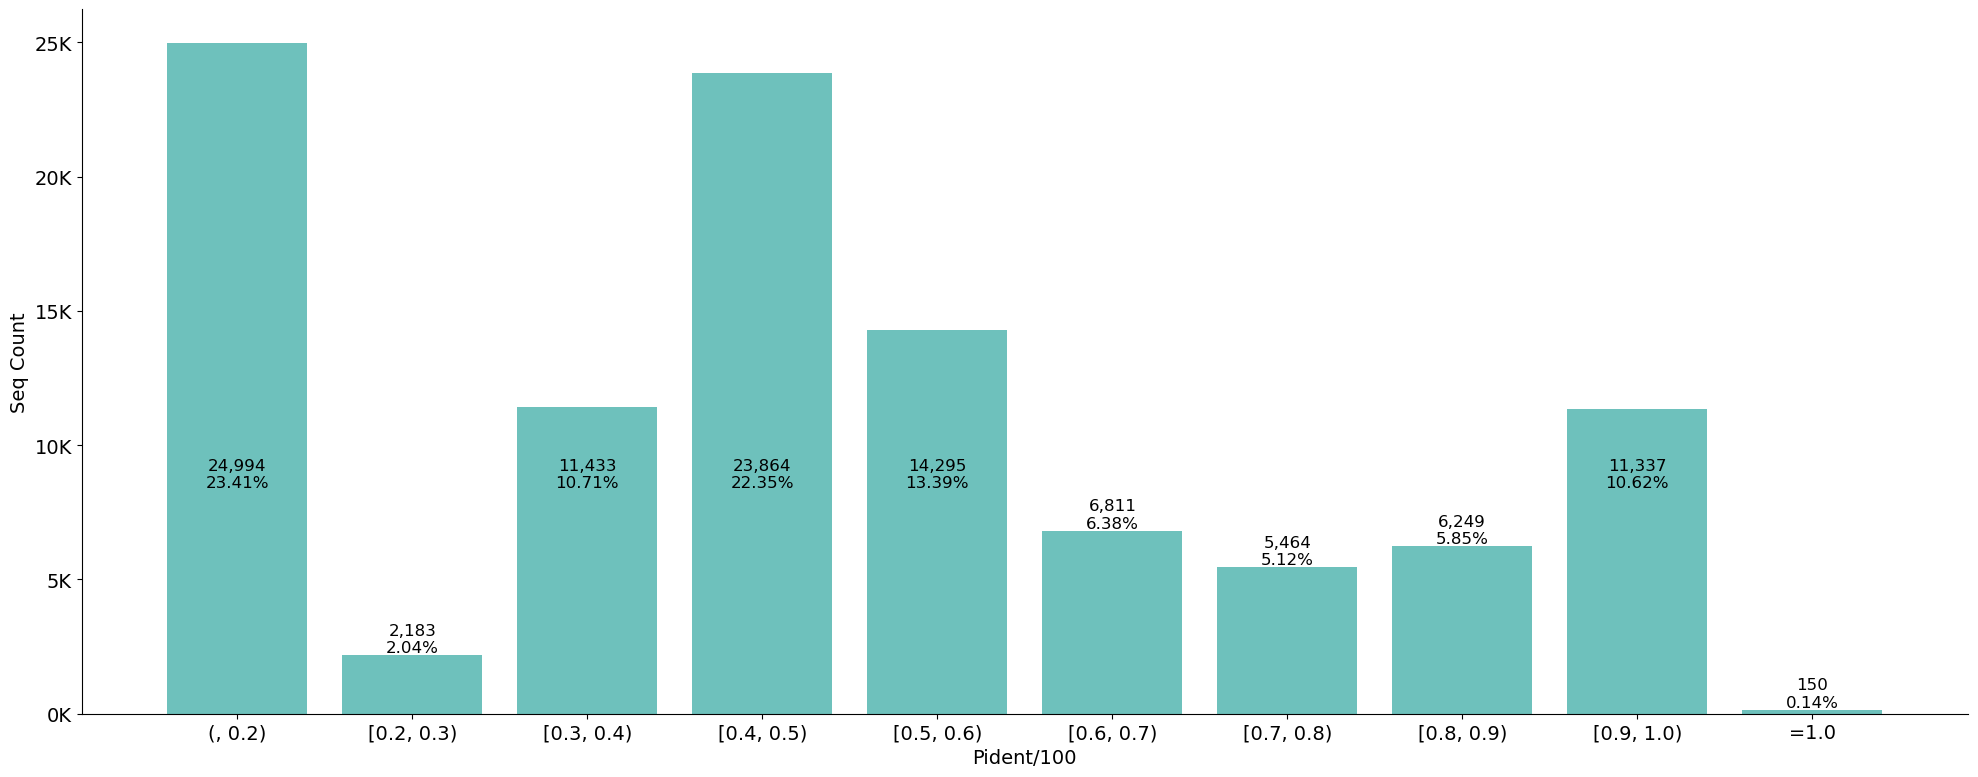

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['font.size'] = 14

# 数据准备
categories = sim_section_names
values_test = sim_section_test
sum_value_test = sum(values_test)

plt.figure(figsize=(20, 8))

# 绘制柱状图
plt.bar(categories, values_test, color='#6ec1bc')

for i, value in enumerate(values_test):
    y =  min(max(values_test)/3, value)
    plt.text(
        i, 
        y, 
        f"{value:,}" + "\n" + str(round(100 * value/sum_value_test, 2)) + "%", 
        ha='center', 
        va='bottom',
        fontsize=12
    )

# 添加标题和标签
# plt.title('Similarity Distribution')
plt.xlabel('Pident/100')
plt.ylabel('Seq Count')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 定义格式化函数
def thousands_formatter(x, pos):
    return f'{int(x/1000)}K'

# 应用格式化到y轴
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

# 调整布局防止重叠
plt.tight_layout()  

# 显示图形
plt.savefig("./pic/Fig.LucapCycle_Extra_P_2_Class_v3_case_01_test_against_train.png", dpi=600,  format='png')
plt.savefig("./pic/Fig.LucapCycle_Extra_P_2_Class_v3_case_01_test_against_train.pdf", dpi=600,  format='pdf')

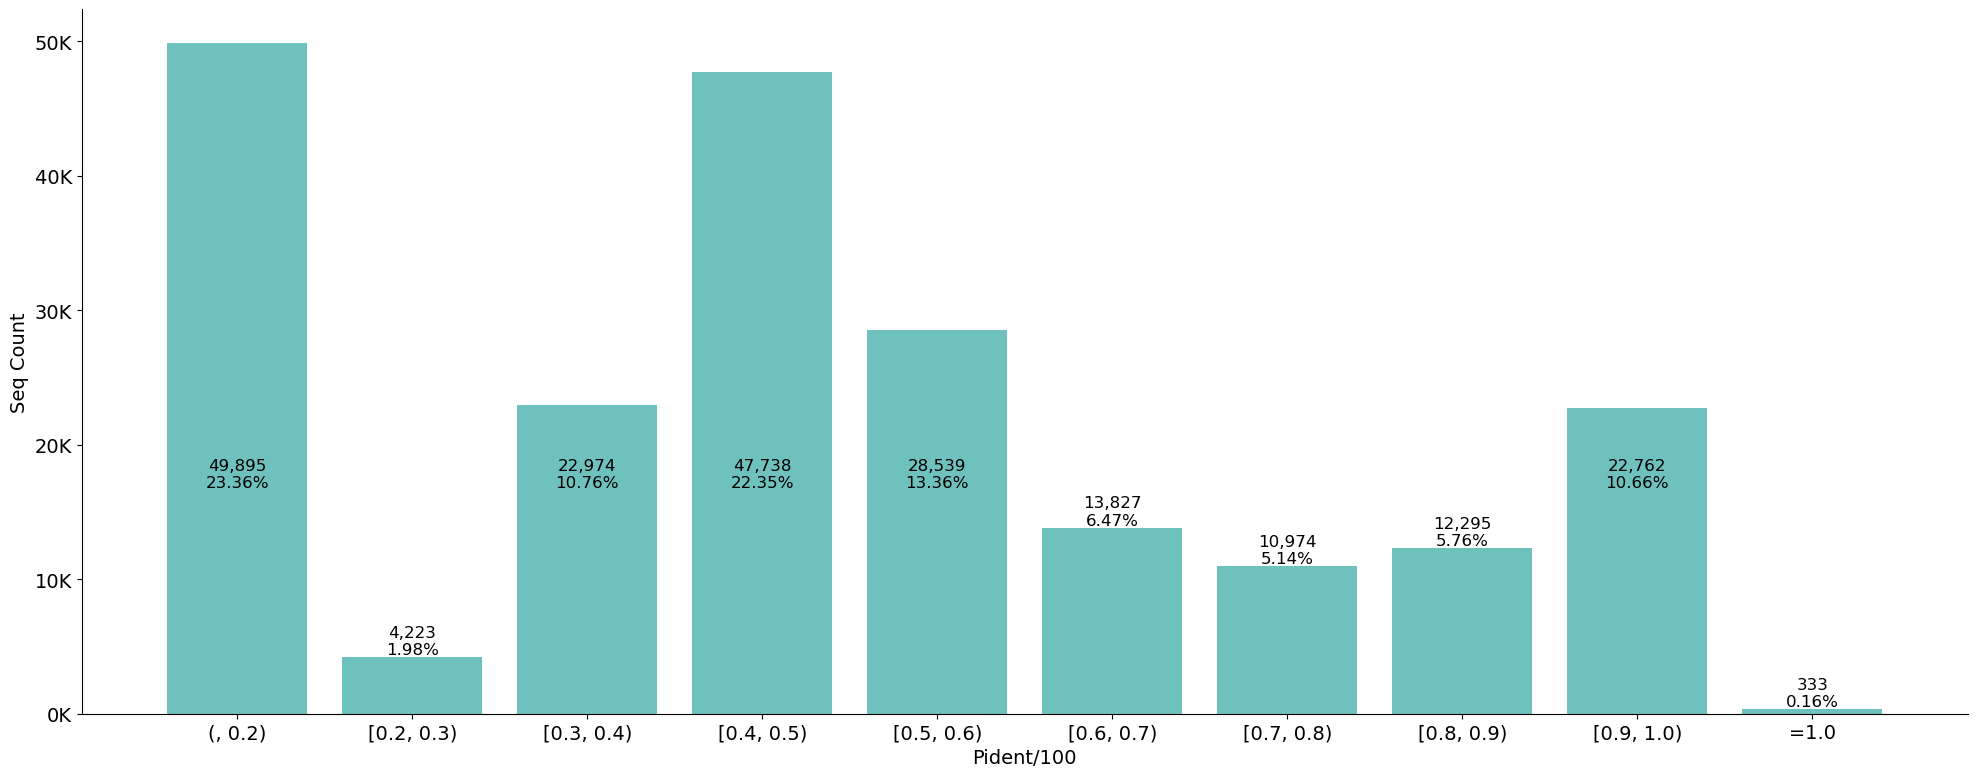

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['font.size'] = 14

# 数据准备
categories = sim_section_names
values_dev_test = sim_section_dev_test
sum_value_dev_test = sum(values_dev_test)

plt.figure(figsize=(20, 8))

# 绘制柱状图
plt.bar(categories, values_dev_test, color='#6ec1bc')

for i, value in enumerate(values_dev_test):
    y =  min(max(values_dev_test)/3, value)
    plt.text(
        i, 
        y, 
        f"{value:,}" + "\n" + str(round(100 * value/sum_value_dev_test, 2)) + "%", 
        ha='center', 
        va='bottom',
        fontsize=12
    )

# 添加标题和标签
# plt.title('Similarity Distribution')
plt.xlabel('Pident/100')
plt.ylabel('Seq Count')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 定义格式化函数
def thousands_formatter(x, pos):
    return f'{int(x/1000)}K'

# 应用格式化到y轴
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

# 调整布局防止重叠
plt.tight_layout()  

# 显示图形
plt.savefig("./pic/Fig.LucapCycle_Extra_P_2_Class_v3_case_01_dev_test_against_train.png", dpi=600,  format='png')
plt.savefig("./pic/Fig.LucapCycle_Extra_P_2_Class_v3_case_01_dev_test_against_train.pdf", dpi=600,  format='pdf')

In [11]:
accumulated_value = 0
for idx, value in enumerate(sim_section_dev_test):
    accumulated_value += value
    print("categories: %s" % categories[idx])
    print("accumulated_value: %d" % accumulated_value)
    print("accumulated_rate: %d/%d=%.4f" %(accumulated_value, sum_value_dev_test, accumulated_value/sum_value_dev_test))

categories: (, 0.2)
accumulated_value: 49895
accumulated_rate: 49895/213560=0.2336
categories: [0.2, 0.3)
accumulated_value: 54118
accumulated_rate: 54118/213560=0.2534
categories: [0.3, 0.4)
accumulated_value: 77092
accumulated_rate: 77092/213560=0.3610
categories: [0.4, 0.5)
accumulated_value: 124830
accumulated_rate: 124830/213560=0.5845
categories: [0.5, 0.6)
accumulated_value: 153369
accumulated_rate: 153369/213560=0.7182
categories: [0.6, 0.7)
accumulated_value: 167196
accumulated_rate: 167196/213560=0.7829
categories: [0.7, 0.8)
accumulated_value: 178170
accumulated_rate: 178170/213560=0.8343
categories: [0.8, 0.9)
accumulated_value: 190465
accumulated_rate: 190465/213560=0.8919
categories: [0.9, 1.0)
accumulated_value: 213227
accumulated_rate: 213227/213560=0.9984
categories: =1.0
accumulated_value: 213560
accumulated_rate: 213560/213560=1.0000
